In [1]:
!pip install mne pymatreader


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 29.3 MB/s eta 0:00:00


In [2]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert
import os


Modelling

In [27]:
import pandas as pd
df=pd.read_csv('/content/TA_final.csv')

In [28]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 150 entries, unnamed: 0 to F4_Fz_theta
dtypes: float64(141), int64(4), object(5)
memory usage: 117.3+ KB


,unnamed: 0,travel_time,trait_anx,pre_saa,post_saa,pre_cort,post_cort,total_reward,patch_switching_freq,fp1_en,...,SD_Ch20,SD_Ch21,SD_Ch22,SD_Ch23,SD_Ch24,SD_Ch25,SD_Ch26,F3_F4_theta,F3_Fz_theta,F4_Fz_theta
count,100.000000,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,51.500000,3.0,43.260000,7.304516,7.859140,28.039343,31.486206,4266.760000,17.473500,0.716732,...,2.067921,2.182121,2.299898,2.410956,2.512692,2.628398,2.757690,0.769252,0.865470,0.884312
std,29.011492,0.0,9.910325,11.316967,14.045471,43.158952,46.324865,862.312303,7.029498,0.266619,...,0.190132,0.199881,0.209335,0.217304,0.231190,0.241556,0.249002,0.081699,0.053829,0.048335
min,2.000000,3.0,26.000000,2.133621,2.069999,0.155637,0.263476,1707.000000,9.460000,0.140762,...,1.735617,1.832676,1.950829,2.057020,2.115488,2.215774,2.330568,0.591511,0.713733,0.762443
25%,26.750000,3.0,38.000000,3.357013,3.403617,1.384727,2.825317,3808.750000,11.495000,0.538424,...,1.936037,2.030874,2.153188,2.236445,2.344305,2.442009,2.576591,0.708895,0.839836,0.851162
50%,51.500000,3.0,41.000000,3.611390,3.766366,6.263508,10.519352,4165.500000,15.755000,0.758151,...,2.039467,2.154067,2.267763,2.379193,2.476691,2.586442,2.717172,0.764544,0.871331,0.892222
75%,76.250000,3.0,48.000000,4.777942,4.486282,30.019257,32.929173,5020.500000,20.682500,0.906629,...,2.186531,2.303157,2.428078,2.546419,2.657264,2.776586,2.912541,0.833657,0.902159,0.922163
max,101.000000,3.0,72.000000,67.926691,91.374989,146.987100,164.512821,6151.000000,38.090000,1.222588,...,2.669903,2.811134,2.946510,3.082267,3.221404,3.367995,3.522065,0.936918,0.965320,0.989713


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

In [30]:

# 4. Handle missing values
# Impute numerical features with median, categorical with mode
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')


In [31]:
# 5. Encode target and categorical features
le = LabelEncoder()
df['trait_anx_level_enc'] = le.fit_transform(df['trait_anx_level'])

In [32]:
# 6. Feature / target split
y = df['trait_anx_level_enc']
X = df.drop(columns=['trait_anx_level','trait_anx_level_enc','unnamed: 0','travel_time','subject_id','environment','id','trait_anx','gender'])

In [33]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load your DataFrame (adjust as needed)
# df = pd.read_csv('your_file.csv')

# Columns to retain (including all EEG channels for inspection if needed)
columns_to_keep = [
    'unnamed: 0', 'travel_time', 'subject_id', 'environment', 'id', 'trait_anx',
    'gender', 'trait_anx_level', 'pre_saa', 'post_saa', 'pre_cort', 'post_cort',
    'total_reward', 'patch_switching_freq'
]

# Generic PCA function for grouped columns by prefix
def apply_pca_to_group(df, prefix_or_list, group_name=None, n_components=3):
    if isinstance(prefix_or_list, list):
        group_cols = prefix_or_list
    else:
        group_cols = [col for col in df.columns if col.startswith(prefix_or_list)]

    if not group_cols:
        return pd.DataFrame()  # Skip if no matching columns

    scaled = StandardScaler().fit_transform(df[group_cols])
    pca = PCA(n_components=min(n_components, len(group_cols)))
    reduced = pca.fit_transform(scaled)

    if group_name is None:
        group_name = prefix_or_list.rstrip('_')

    reduced_df = pd.DataFrame(reduced, columns=[f'{group_name}_pca_{i+1}' for i in range(reduced.shape[1])])
    return reduced_df

# Frequency-band-based PCA (by prefix matching)
theta_alpha_pca = apply_pca_to_group(df, 'theta_alpha_channel_', group_name='theta_alpha', n_components=3)
theta_beta_pca  = apply_pca_to_group(df, 'channel_', group_name='theta_beta', n_components=3)
theta_gamma_pca = apply_pca_to_group(df, 'channel_', group_name='theta_gamma', n_components=3)
sd_pca          = apply_pca_to_group(df, 'SD_Ch', group_name='sd', n_components=3)

# EEG anatomical region groupings
frontal = ['fp1_en', 'fp2_en', 'f3_en', 'f4_en', 'f7_en', 'f8_en', 'fz_en']
central = ['c3_en', 'c4_en', 'cz_en', 'fc2_en', 'fc5_en', 'fc6_en', 'fcz_en']
parietal = ['p3_en', 'p4_en', 'p7_en', 'p8_en', 'pz_en', 'cp1_en', 'cp2_en', 'cp5_en', 'cp6_en']
occipital = ['o1_en', 'o2_en', 'io_en']

# Apply PCA to anatomical groups
pca_frontal = apply_pca_to_group(df, frontal, group_name='frontal', n_components=2)
pca_central = apply_pca_to_group(df, central, group_name='central', n_components=2)
pca_parietal = apply_pca_to_group(df, parietal, group_name='parietal', n_components=2)
pca_occipital = apply_pca_to_group(df, occipital, group_name='occipital', n_components=1)

# Final feature dataframe combination
final_df = pd.concat([
    df[columns_to_keep].reset_index(drop=True),
    theta_alpha_pca,
    theta_beta_pca,
    theta_gamma_pca,
    sd_pca,
    pca_frontal,
    pca_central,
    pca_parietal,
    pca_occipital,
    df[['f3_f4', 'f3_fz', 'f4_fz', 'F3_F4_theta', 'F3_Fz_theta', 'F4_Fz_theta']].reset_index(drop=True)
], axis=1)

# Save to CSV
final_df.to_csv("eeg_pca_processed.csv", index=False)


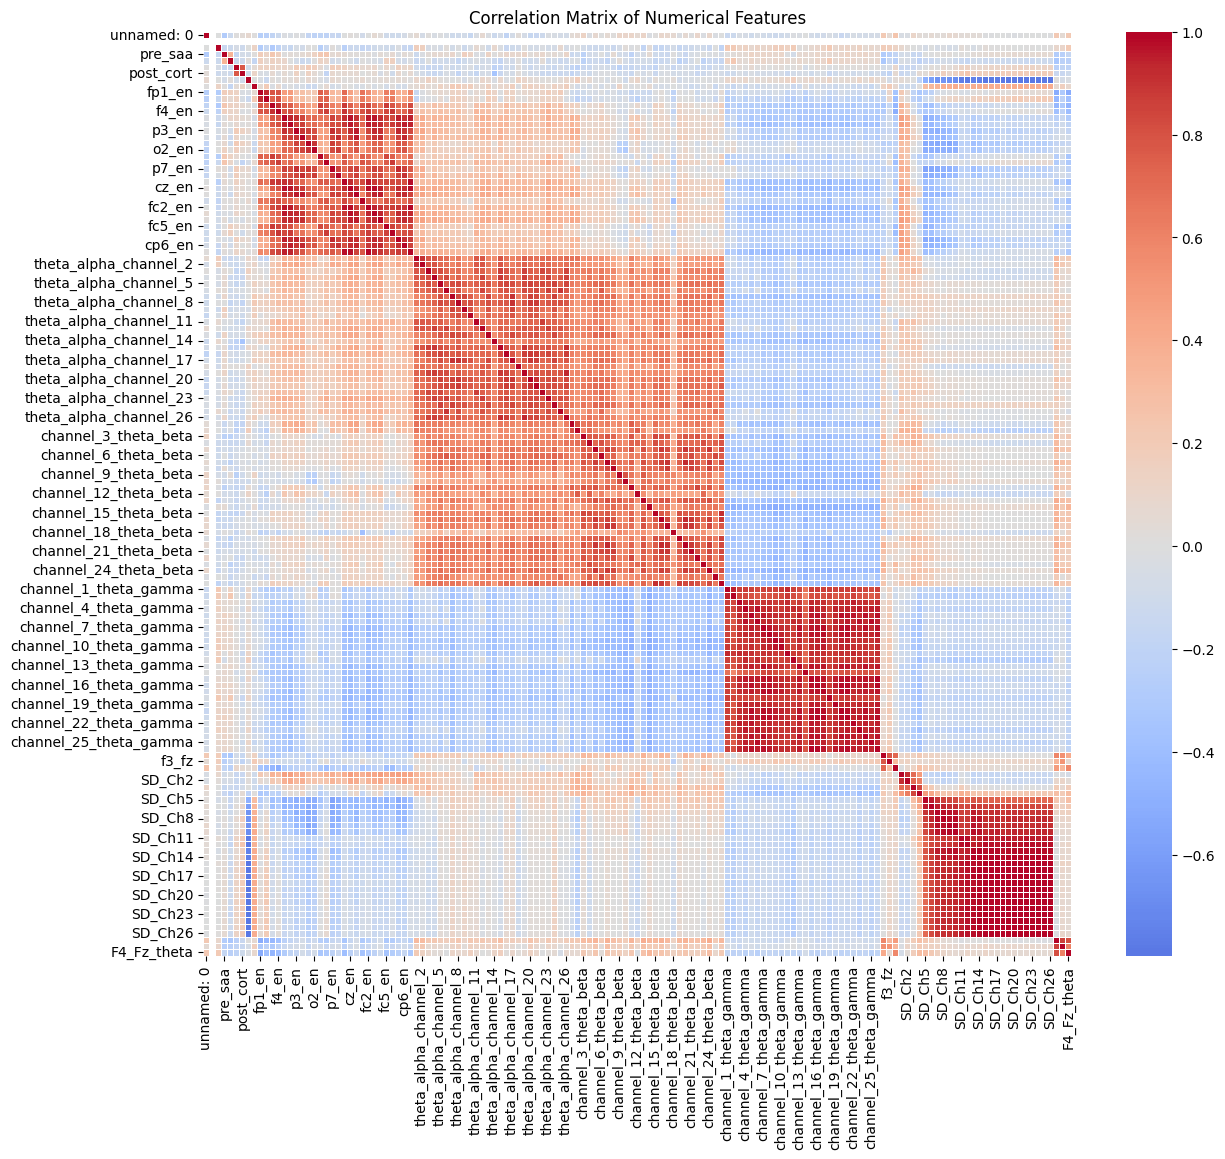

In [34]:
plt.figure(figsize=(14, 12))
corr = df[num_cols].corr()
sns.heatmap(corr, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

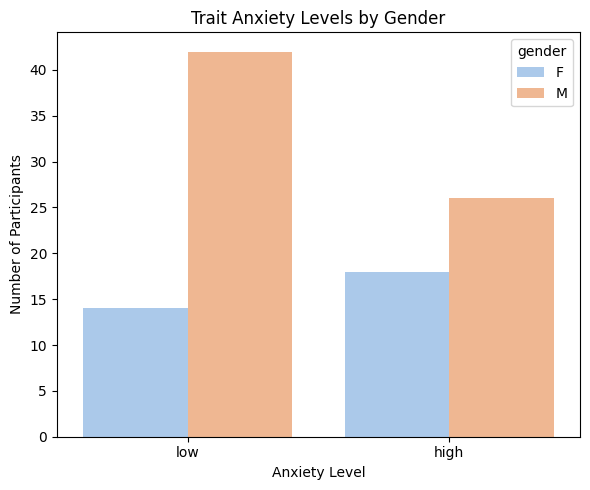

In [35]:
plt.figure(figsize=(6, 5))
sns.countplot(data=df, x='trait_anx_level', hue='gender', palette='pastel')
plt.title('Trait Anxiety Levels by Gender')
plt.xlabel('Anxiety Level')
plt.ylabel('Number of Participants')
plt.tight_layout()
plt.show()


<ipython-input-36-0028c37ecf54>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='trait_anx_level', y='F3_F4_theta', palette='coolwarm')


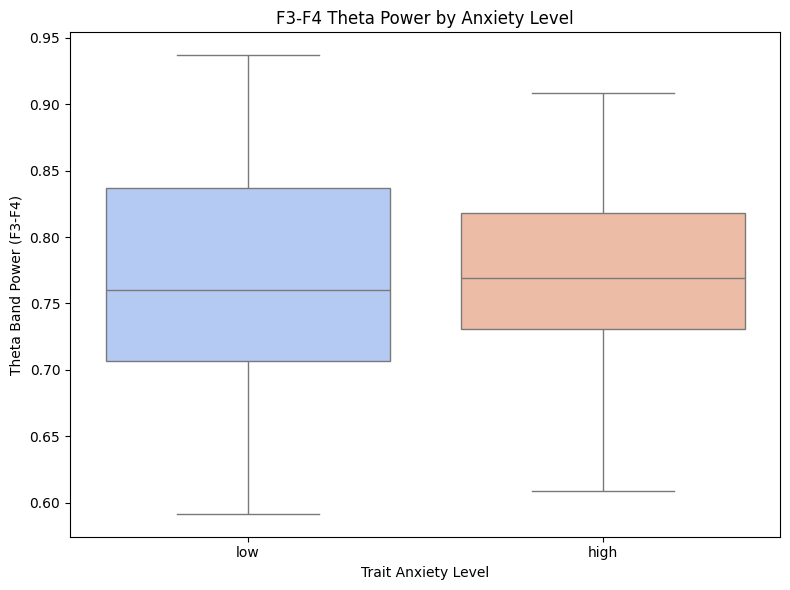

In [36]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='trait_anx_level', y='F3_F4_theta', palette='coolwarm')
plt.title('F3-F4 Theta Power by Anxiety Level')
plt.ylabel('Theta Band Power (F3-F4)')
plt.xlabel('Trait Anxiety Level')
plt.tight_layout()
plt.show()


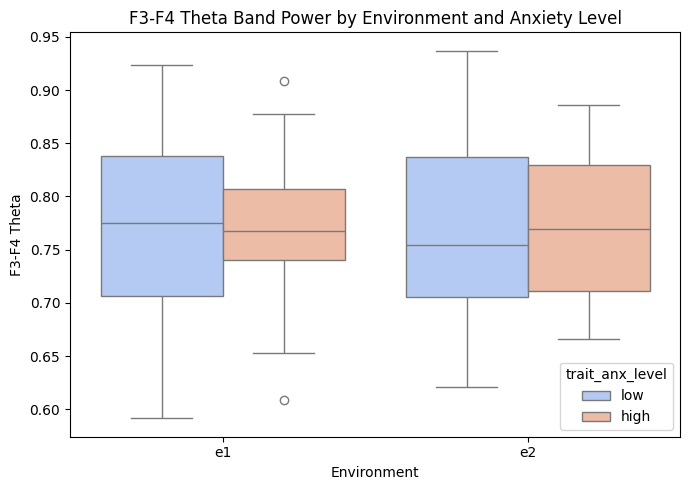

In [38]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=df, x='environment', y='F3_F4_theta', hue='trait_anx_level', palette='coolwarm')
plt.title('F3-F4 Theta Band Power by Environment and Anxiety Level')
plt.xlabel('Environment')
plt.ylabel('F3-F4 Theta')
plt.tight_layout()
plt.show()


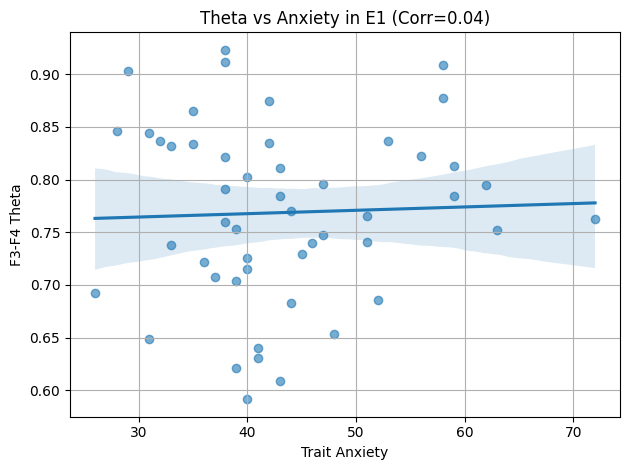

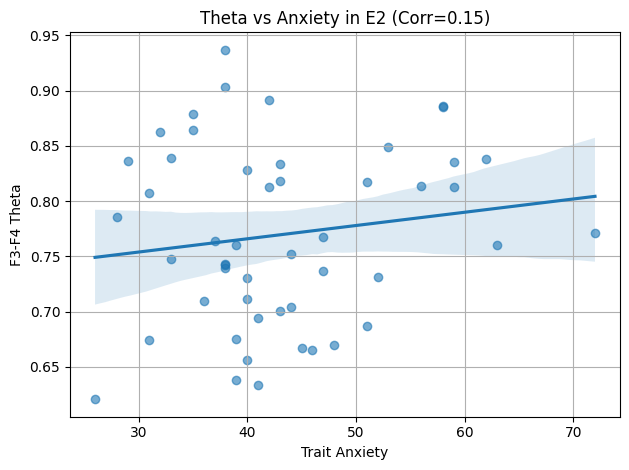

In [39]:
for env in ['e1', 'e2']:
    subset = df[df['environment'] == env]
    corr = subset['F3_F4_theta'].corr(subset['trait_anx'])
    sns.regplot(data=subset, x='trait_anx', y='F3_F4_theta', scatter_kws={'alpha': 0.6})
    plt.title(f'Theta vs Anxiety in {env.upper()} (Corr={corr:.2f})')
    plt.xlabel('Trait Anxiety')
    plt.ylabel('F3-F4 Theta')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [11]:
df=final_df

In [58]:
df

,unnamed: 0,travel_time,subject_id,environment,id,trait_anx,gender,trait_anx_level,pre_saa,post_saa,...,SD_Ch21,SD_Ch22,SD_Ch23,SD_Ch24,SD_Ch25,SD_Ch26,F3_F4_theta,F3_Fz_theta,F4_Fz_theta,trait_anx_level_enc
0,2,3,p2,e1,p2e1,40,F,low,67.926691,33.242639,...,2.323949,2.448438,2.559333,2.681443,2.793338,2.942090,0.591511,0.751865,0.831779,1
1,3,3,p2,e2,p2e2,40,F,low,67.926691,33.242639,...,2.236502,2.356954,2.457591,2.579662,2.689818,2.826633,0.655822,0.754214,0.869346,1
2,4,3,p3,e1,p3e1,45,M,high,2.617566,3.516061,...,2.075824,2.174238,2.292225,2.371586,2.488037,2.620785,0.729207,0.850478,0.845125,0
3,5,3,p3,e2,p3e2,45,M,high,2.617566,3.516061,...,2.154719,2.251570,2.377917,2.464296,2.582785,2.716161,0.666994,0.856318,0.810870,0
4,6,3,p4,e1,p4e1,58,M,high,3.652220,4.352831,...,1.860421,1.987060,2.087508,2.143339,2.237350,2.375960,0.908584,0.965320,0.951152,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,97,3,p51,e2,p51e2,47,F,high,3.463154,4.294995,...,2.097276,2.212464,2.324717,2.412824,2.524268,2.657556,0.767715,0.868134,0.895002,0
96,98,3,p53,e1,p53e1,59,M,high,2.133621,11.507361,...,1.950929,2.059535,2.162562,2.241467,2.349669,2.471653,0.784065,0.898564,0.892338,0
97,99,3,p53,e2,p53e2,59,M,high,2.133621,11.507361,...,2.226110,2.345198,2.461545,2.564417,2.684555,2.808738,0.812803,0.916843,0.910227,0
98,100,3,p54,e1,p54e1,39,M,low,8.704217,12.686411,...,1.850055,1.978919,2.065030,2.145356,2.225405,2.354203,0.752950,0.853041,0.844155,1


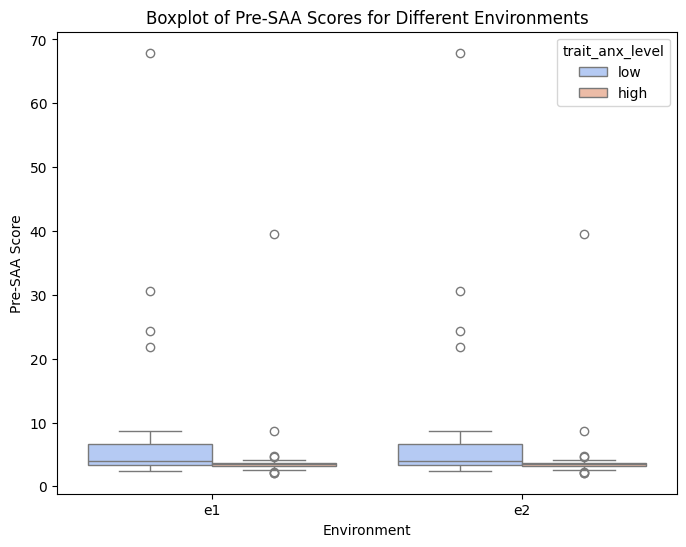

In [55]:
# 2. Boxplot of Trait Anxiety Level for different environments
plt.figure(figsize=(8, 6))
sns.boxplot(data=final_df, x='environment', y='pre_saa', hue='trait_anx_level', palette='coolwarm')
plt.title('Boxplot of Pre-SAA Scores for Different Environments')
plt.xlabel('Environment')
plt.ylabel('Pre-SAA Score')
plt.show()

In [41]:
df

,unnamed: 0,travel_time,subject_id,environment,id,trait_anx,gender,trait_anx_level,pre_saa,post_saa,...,SD_Ch21,SD_Ch22,SD_Ch23,SD_Ch24,SD_Ch25,SD_Ch26,F3_F4_theta,F3_Fz_theta,F4_Fz_theta,trait_anx_level_enc
0,2,3,p2,e1,p2e1,40,F,low,67.926691,33.242639,...,2.323949,2.448438,2.559333,2.681443,2.793338,2.942090,0.591511,0.751865,0.831779,1
1,3,3,p2,e2,p2e2,40,F,low,67.926691,33.242639,...,2.236502,2.356954,2.457591,2.579662,2.689818,2.826633,0.655822,0.754214,0.869346,1
2,4,3,p3,e1,p3e1,45,M,high,2.617566,3.516061,...,2.075824,2.174238,2.292225,2.371586,2.488037,2.620785,0.729207,0.850478,0.845125,0
3,5,3,p3,e2,p3e2,45,M,high,2.617566,3.516061,...,2.154719,2.251570,2.377917,2.464296,2.582785,2.716161,0.666994,0.856318,0.810870,0
4,6,3,p4,e1,p4e1,58,M,high,3.652220,4.352831,...,1.860421,1.987060,2.087508,2.143339,2.237350,2.375960,0.908584,0.965320,0.951152,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,97,3,p51,e2,p51e2,47,F,high,3.463154,4.294995,...,2.097276,2.212464,2.324717,2.412824,2.524268,2.657556,0.767715,0.868134,0.895002,0
96,98,3,p53,e1,p53e1,59,M,high,2.133621,11.507361,...,1.950929,2.059535,2.162562,2.241467,2.349669,2.471653,0.784065,0.898564,0.892338,0
97,99,3,p53,e2,p53e2,59,M,high,2.133621,11.507361,...,2.226110,2.345198,2.461545,2.564417,2.684555,2.808738,0.812803,0.916843,0.910227,0
98,100,3,p54,e1,p54e1,39,M,low,8.704217,12.686411,...,1.850055,1.978919,2.065030,2.145356,2.225405,2.354203,0.752950,0.853041,0.844155,1


In [63]:
# 5. Encode target and categorical features
le = LabelEncoder()
df['trait_anx_level_enc'] = le.fit_transform(df['trait_anx_level'])

In [67]:
print(df.columns)


Index(['unnamed: 0', 'travel_time', 'subject_id', 'environment', 'id',
       'trait_anx', 'gender', 'trait_anx_level', 'pre_saa', 'post_saa',
       ...
       'SD_Ch21', 'SD_Ch22', 'SD_Ch23', 'SD_Ch24', 'SD_Ch25', 'SD_Ch26',
       'F3_F4_theta', 'F3_Fz_theta', 'F4_Fz_theta', 'trait_anx_level_enc'],
      dtype='object', length=151)


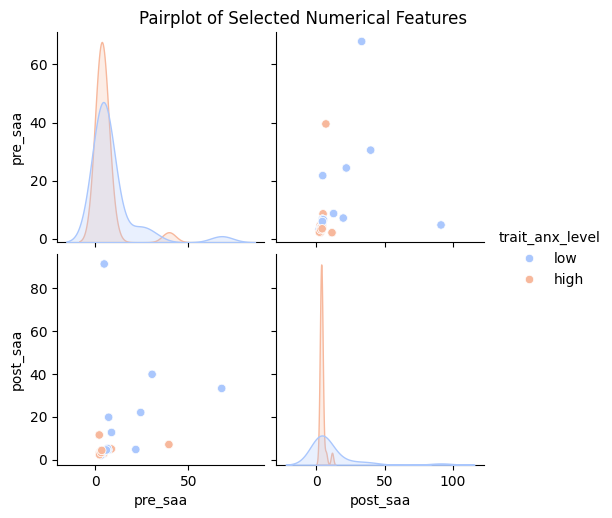

In [73]:
subset_cols = ['pre_saa', 'post_saa','trait_anx_level'] # Include 'trait_anx_level' in the subset
sns.pairplot(df[subset_cols], hue='trait_anx_level', palette='coolwarm')
plt.suptitle('Pairplot of Selected Numerical Features', y=1.02)
plt.show()


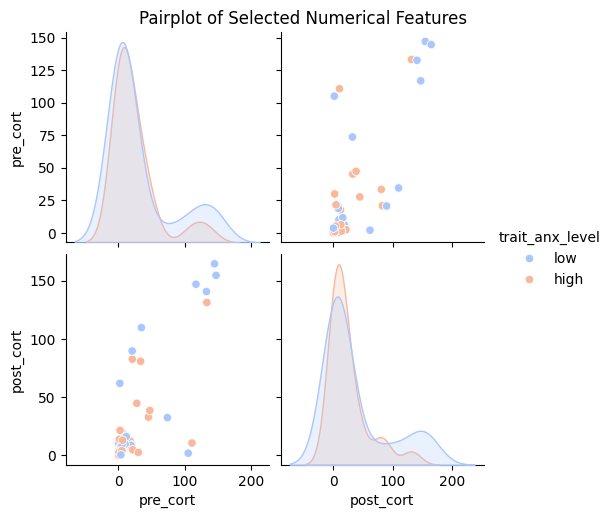

In [74]:
subset_cols = ['pre_cort','post_cort', 'trait_anx_level'] # Include 'trait_anx_level' in the subset
sns.pairplot(df[subset_cols], hue='trait_anx_level', palette='coolwarm')
plt.suptitle('Pairplot of Selected Numerical Features', y=1.02)
plt.show()

In [43]:
# 6. Feature / target split
y = df['trait_anx_level_enc']
X = df.drop(columns=['trait_anx_level','trait_anx_level_enc','unnamed: 0','travel_time','subject_id','environment','id','trait_anx','gender'])

In [44]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)


In [45]:
X=X_normalized

In [46]:
#By using stratify=y, it keeps things fair and balanced across the split.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=y
)

In [47]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Step 2: Apply SMOTE to training data
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)


In [48]:
X_train=X_train_resampled
y_train=y_train_resampled

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

# Define the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Create stratified k-fold cross-validation (preserves class balance in each fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Get cross-validated predictions on the whole dataset
y_pred_rf = cross_val_predict(rf, X, y, cv=cv)

# Evaluate the results
print("Random Forest Report (with Cross-Validation)")
print(classification_report(y, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y, y_pred_rf))


Random Forest Report (with Cross-Validation)
              precision    recall  f1-score   support

           0       0.55      0.39      0.45        44
           1       0.61      0.75      0.67        56

    accuracy                           0.59       100
   macro avg       0.58      0.57      0.56       100
weighted avg       0.58      0.59      0.58       100

Confusion Matrix:
 [[17 27]
 [14 42]]


In [50]:
from sklearn.model_selection import cross_val_score

# Cross-validated accuracy scores
scores = cross_val_score(rf, X, y, cv=cv, scoring='accuracy')

print("Cross-validated accuracy scores:", scores)
print("Mean accuracy:", scores.mean())


Cross-validated accuracy scores: [0.6  0.65 0.55 0.6  0.55]
Mean accuracy: 0.5900000000000001


In [51]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Report")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Random Forest Report
              precision    recall  f1-score   support

           0       0.75      0.67      0.71         9
           1       0.75      0.82      0.78        11

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20

Confusion Matrix:
 [[6 3]
 [2 9]]


In [52]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10]
}
grid = GridSearchCV(rf, param_grid, cv=5, scoring='f1_macro')
grid.fit(X_train, y_train)

print("Best RF params:", grid.best_params_)
best_rf = grid.best_estimator_
print(classification_report(y_test, best_rf.predict(X_test)))


Best RF params: {'max_depth': None, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.88      0.78      0.82         9
           1       0.83      0.91      0.87        11

    accuracy                           0.85        20
   macro avg       0.85      0.84      0.85        20
weighted avg       0.85      0.85      0.85        20



In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Scale the data (Neural nets love scaled inputs)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Use 'softmax' for multiclass
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=100, batch_size=16, verbose=0)

# Predict on test data
y_pred_nn = (model.predict(X_test_scaled) > 0.5).astype("int32")

# Evaluate
print("Neural Network Report")
print(classification_report(y_test, y_pred_nn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nn))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Neural Network Report
              precision    recall  f1-score   support

           0       0.70      0.78      0.74         9
           1       0.80      0.73      0.76        11

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20

Confusion Matrix:
 [[7 2]
 [3 8]]
